In [1]:
# Matlab plots inline
%matplotlib inline

# Auto reload external files after changes
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from image_set import ImgSet
from image_process import ZernikeProc

Loading SHTOOLS documentation


In [3]:
ant_set = ImgSet(name='trees_hr_w', data_folder='../data/world_images')
ant_processed = ZernikeProc(ant_set)

loading from image files in ../data/world_images/trees_hr_w
Extracting Zernike coefficients
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
loading from matrix
Saving to : ../data/world_images/trees_hr_w_zernikem.npz


How many sample points we will take

In [4]:
n = 16

In [5]:
ims_per_row = 201

In [6]:
idxs = np.linspace(0, ims_per_row*(ims_per_row-1), n, dtype='int')
idxs

array([    0,  2680,  5360,  8040, 10720, 13400, 16080, 18760, 21440,
       24120, 26800, 29480, 32160, 34840, 37520, 40200])

In [7]:
Z = sp.spatial.distance.cdist(ant_processed.processed.M[:,idxs].T, ant_processed.processed.M.T, 'euclidean')

Just looking at some random points to see whether we have a gradient

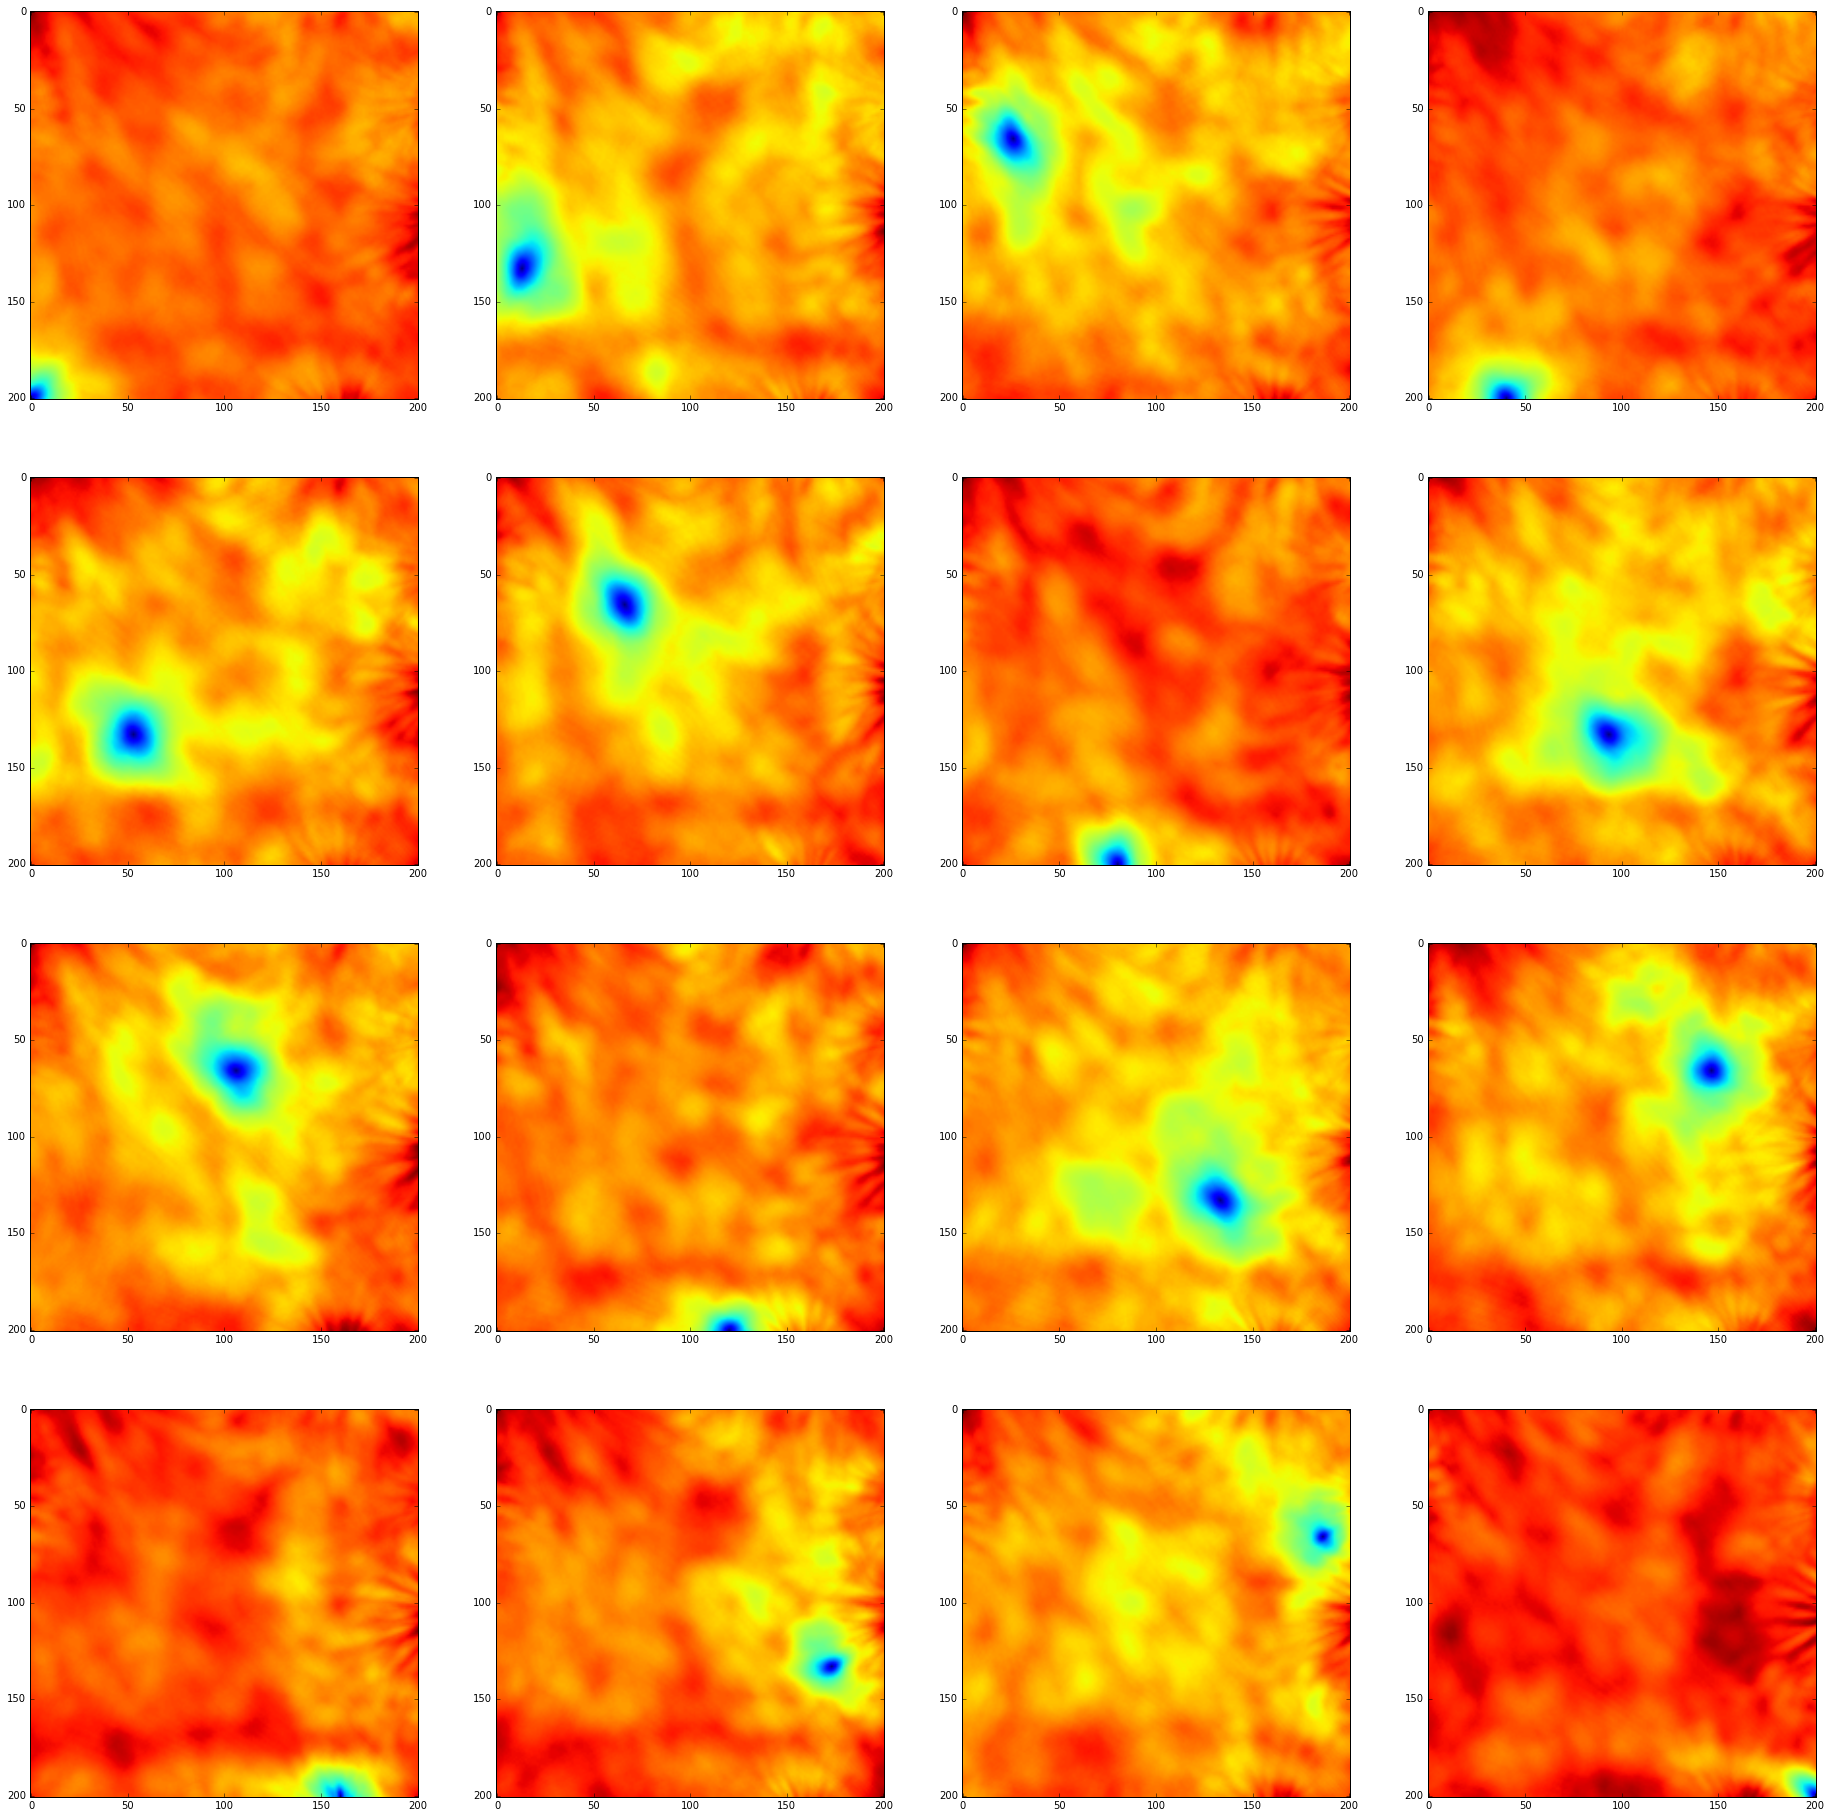

In [8]:
figsize = (32,32)
nrows = 4
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

for r in range(nrows):
    for c in range(ncols):
        M = np.rot90(Z[(r*ncols+c),:].reshape(ims_per_row, ims_per_row))
        axes[r][c].imshow(M, vmin=abs(M).min(), vmax=abs(M).max())

Adding saturation

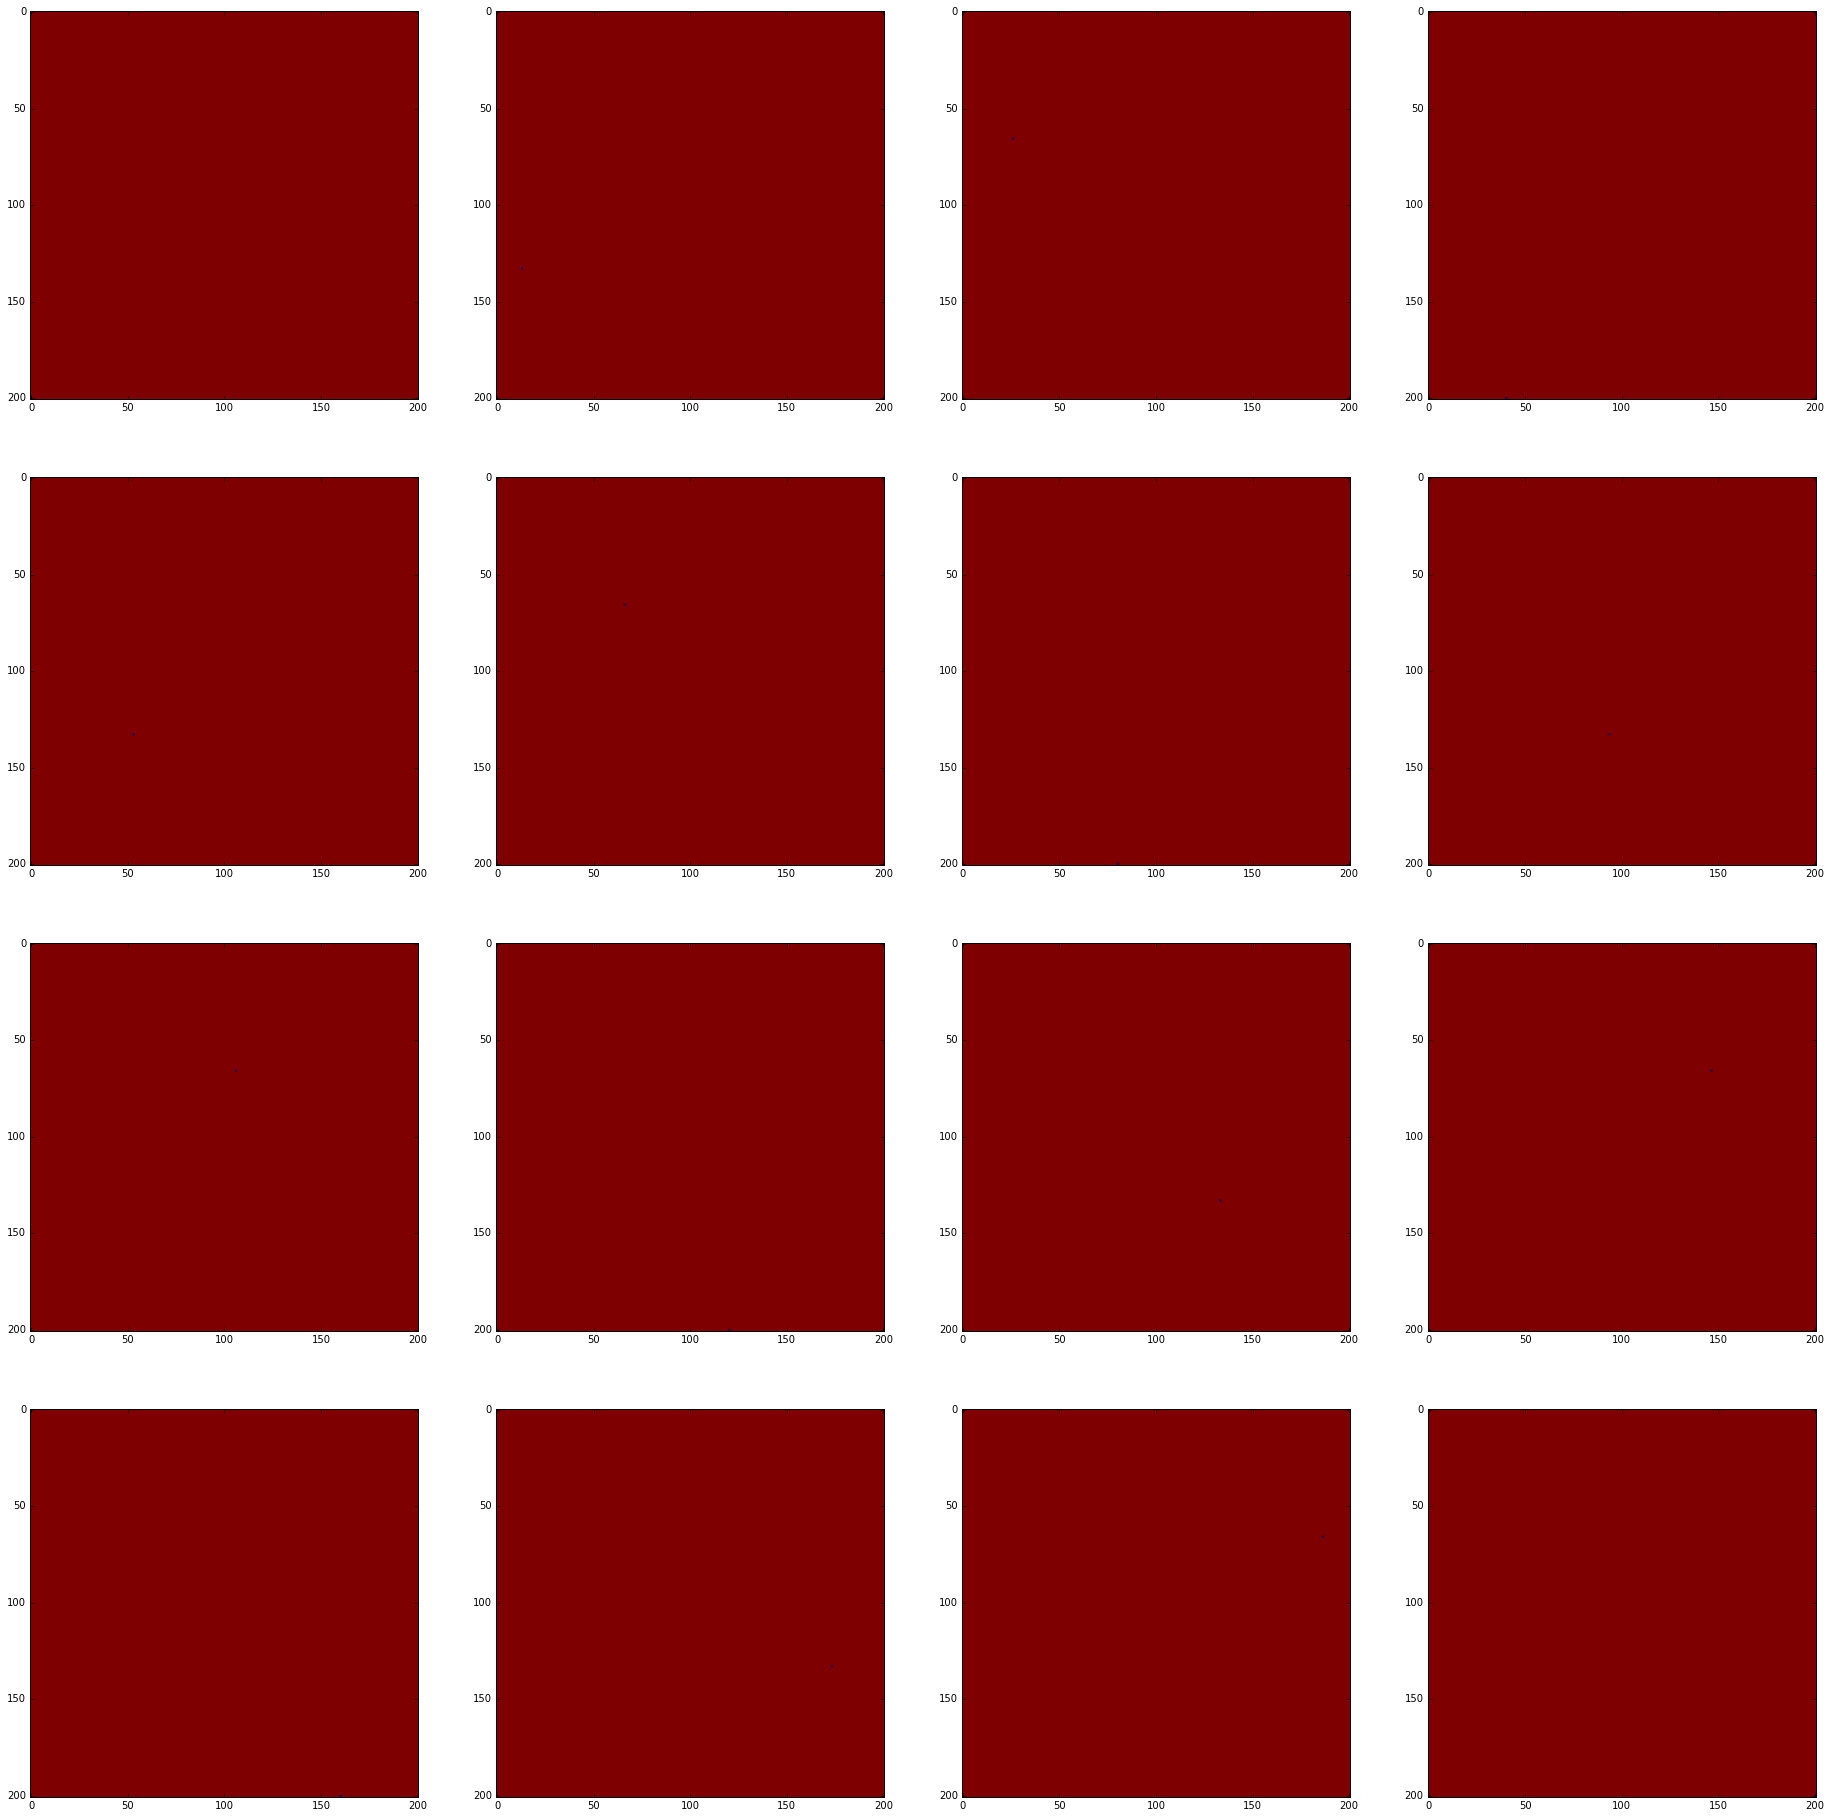

In [9]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

for r in range(nrows):
    for c in range(ncols):
        M = np.rot90(Z[(r*ncols+c),:].reshape(ims_per_row, ims_per_row))
        axes[r][c].imshow(M, vmin=abs(M).min(), vmax=100)

Using a log scale

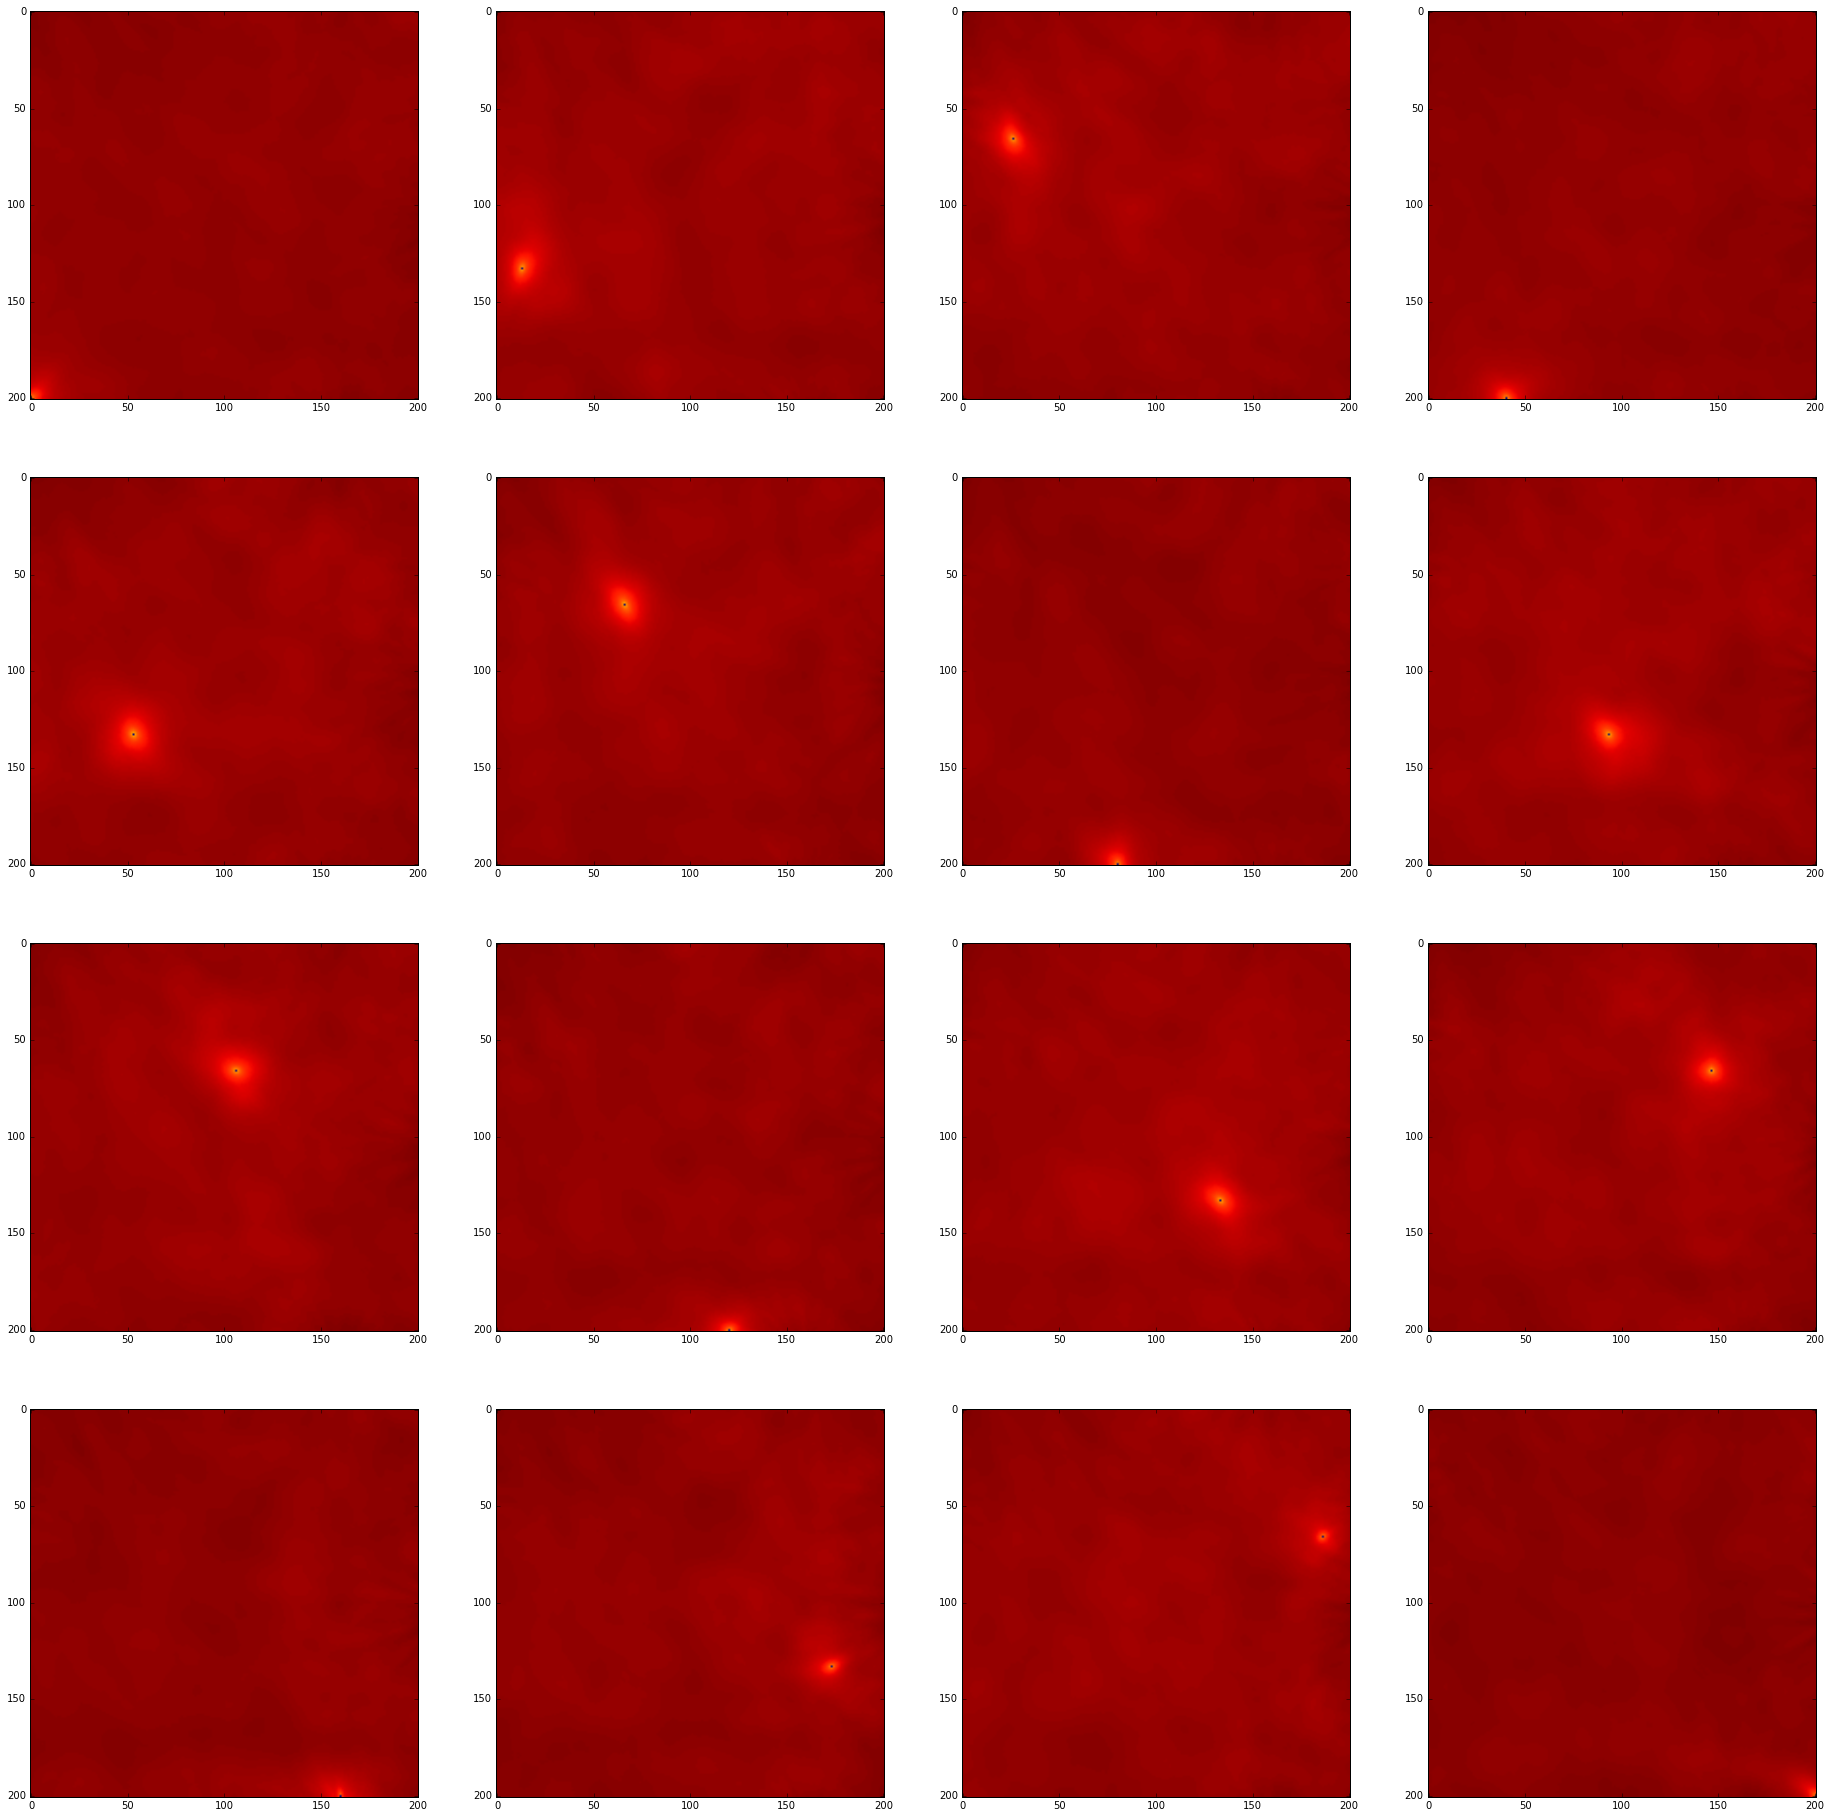

In [10]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

for r in range(nrows):
    for c in range(ncols):
        M = np.rot90(np.log1p(Z[(r*ncols+c),:]).reshape(ims_per_row, ims_per_row))
        axes[r][c].imshow(M, vmin=abs(M).min(), vmax=abs(M).max())

Let's create an artificial ant route...

In [11]:
rand_vm = np.random.vonmises(0, 1.5, size=300)

In [12]:
x_start = 100
y_start = 10

x = np.cumsum(np.sin(rand_vm)).astype('int') + x_start
y = np.cumsum(np.cos(rand_vm)).astype('int') + y_start

(98.0, 112.0, 0.0, 200.0)

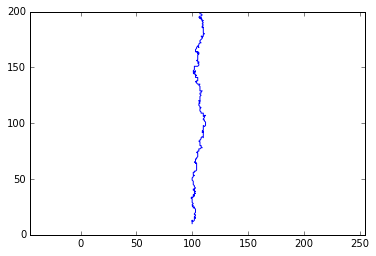

In [13]:
plt.plot(x,y)
plt.axis('equal')

In [14]:
idxs = (x*M.shape[0] + y)

Compare rotation invariant views at all points in the world to each point in the route. For each location choose the lowest (most familiar)

In [15]:
Z_route = sp.spatial.distance.cdist(ant_processed.processed.M[:,idxs].T, ant_processed.processed.M.T, 'euclidean')
Z_best = np.min(Z_route, axis=0).reshape(ims_per_row, ims_per_row)

Let's try visualise the results to see if we have enough gradient to recover the path

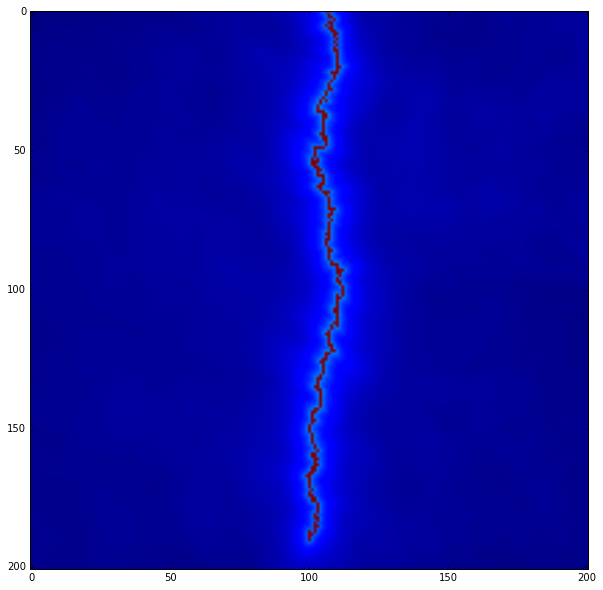

In [16]:
fig, ax = plt.subplots(figsize=(10,10))

M = np.rot90(np.log1p(Z_best))
ax.imshow(-M, vmin=(-M).min(), vmax=(-M).max())

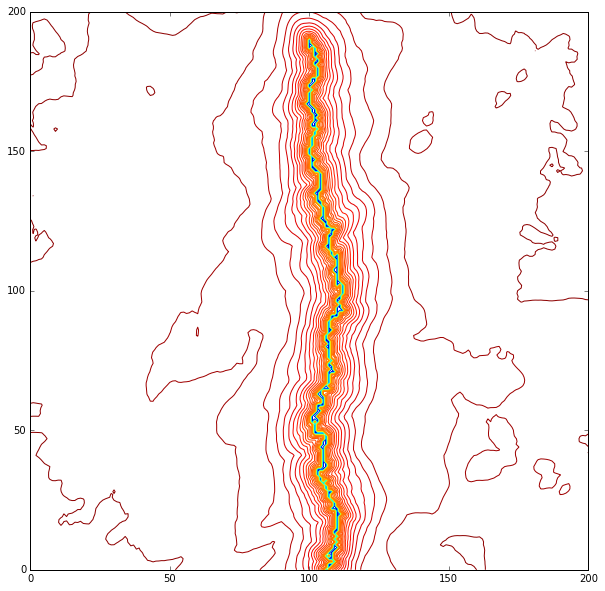

In [17]:
X, Y = np.meshgrid(np.arange(M.shape[0]), np.arange(M.shape[1]))

fig, ax = plt.subplots(figsize=(10,10))
ax.contour(X, Y, M, levels=np.arange(0, np.max(M), 0.2))
#ax.quiver(X[::3,::3],Y[::3,::3],U[::3,::3],V[::3,::3], pivot='mid')

In [18]:
import plotly.plotly as py
from plotly.graph_objs import *

trace1 = Surface(
    z=M,
    x=np.linspace(0,10,M.shape[0]),
    y=np.linspace(0,10,M.shape[1])
)

# Package the trace dictionary into a data object
data = Data([trace1])

layout = Layout(
    title='Smallest difference to all locations on route',
    xaxis=XAxis(
        title='x (metres)'
    ),
    yaxis=YAxis(
        title='y (metres)'
    )
)

# (@) Send to Plotly and show in notebook
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='ant_route_surface')

In [19]:
def gradient_descent(M, step_size=0.5, n_steps=200):

    xs = np.arange(0, M.shape[0])
    ys = np.arange(0, M.shape[1])
    
    spl = sp.interpolate.RectBivariateSpline(xs, ys, M)
    
    XS, YS = np.meshgrid(xs, ys)
    x = XS.astype(np.float64).reshape(-1)
    y = YS.astype(np.float64).reshape(-1)

    for i in range(n_steps):
        dx = spl(x=x, y=y, dx=1, grid=False)
        dy = spl(x=x, y=y, dy=1, grid=False)
        
        v = np.array([dx, dy])
        v_norm = v / np.linalg.norm(v, axis=0)

        x -= step_size * v_norm[0,:]
        np.clip(x, 0, M.shape[0]-1, out=x)

        y -= step_size * v_norm[1,:]
        np.clip(y, 0, M.shape[1]-1, out=y)
        
    return (x, y)

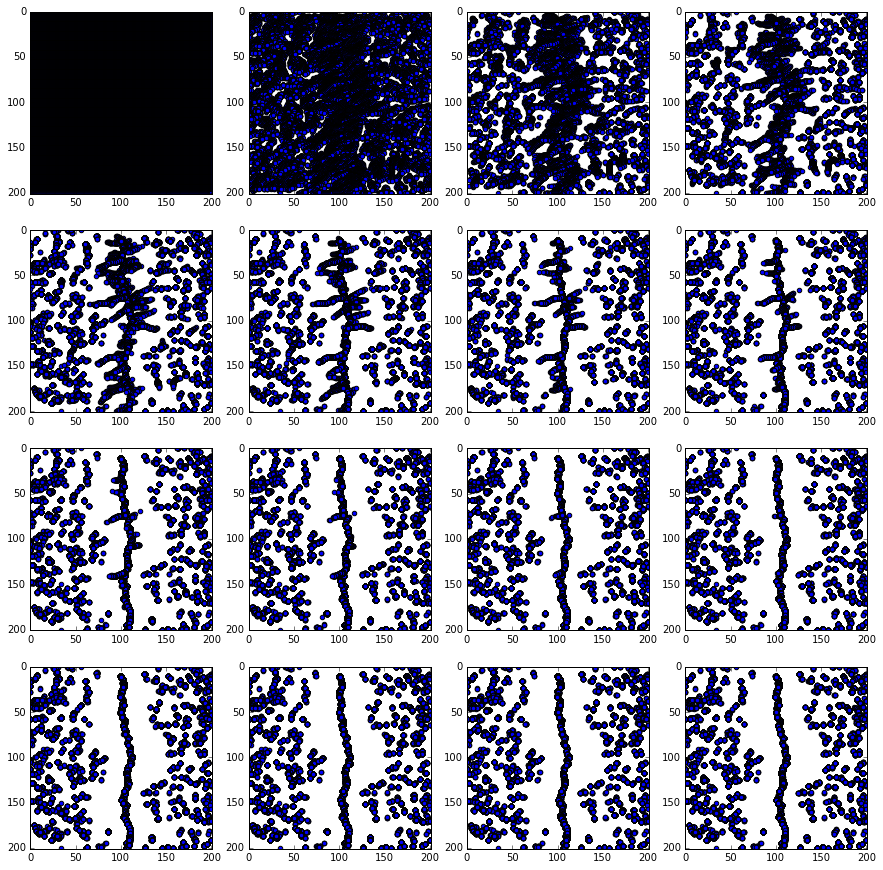

In [20]:
fig, ax = plt.subplots(4, 4, figsize=(15,15))
for i in range(16):
    xxx, yyy = gradient_descent(Z_best, step_size=0.5, n_steps=i*10)
    ax[i/4][i%4].scatter(xxx, yyy)
    ax[i/4][i%4].invert_yaxis()
    ax[i/4][i%4].set_xlim([0, M.shape[0]])
    ax[i/4][i%4].set_ylim([M.shape[1], 0])

In [21]:
x2, y2 = gradient_descent(Z_best, step_size=0.5, n_steps=150)

(201, 0)

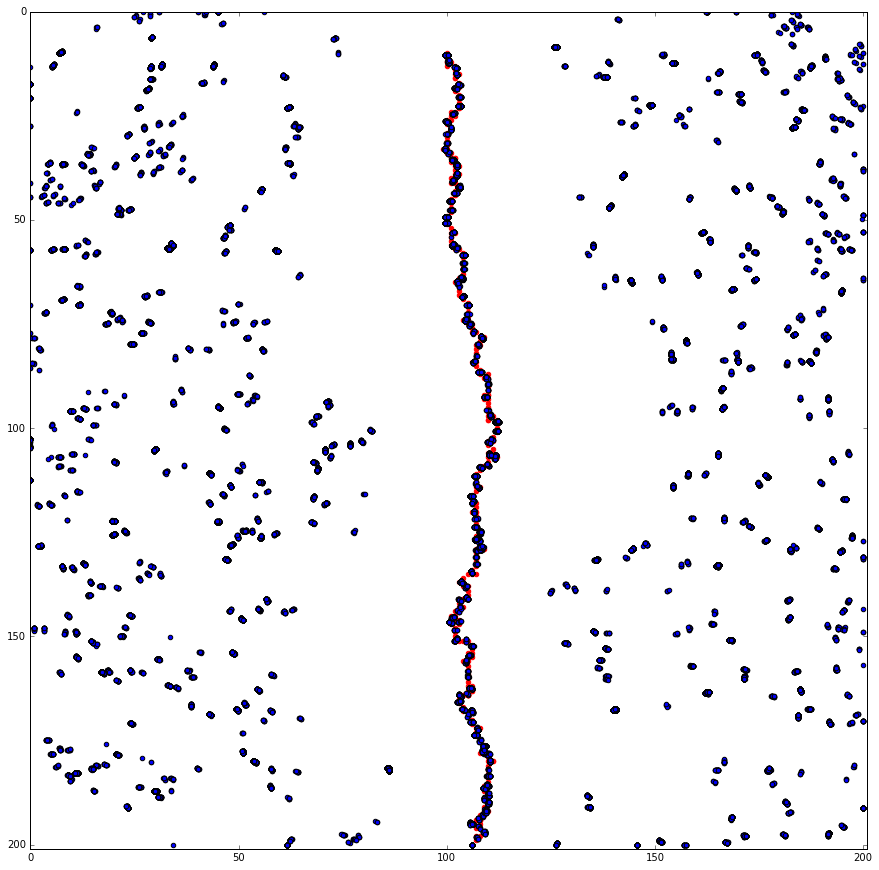

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(x, y, color='r')
ax.scatter(x2, y2)
ax.invert_yaxis()
ax.set_xlim([0, M.shape[0]])
ax.set_ylim([M.shape[1], 0])

In [23]:
threshold = 1

distances = sp.spatial.distance.cdist(np.vstack([x2, y2]).T,
                                      np.vstack([x, y]).T,
                                      'euclidean')

indices = np.min(distances, axis=1) <= threshold
M_catchment = np.flipud(indices.reshape(M.shape)).astype('bool')

Catchment area is 13047


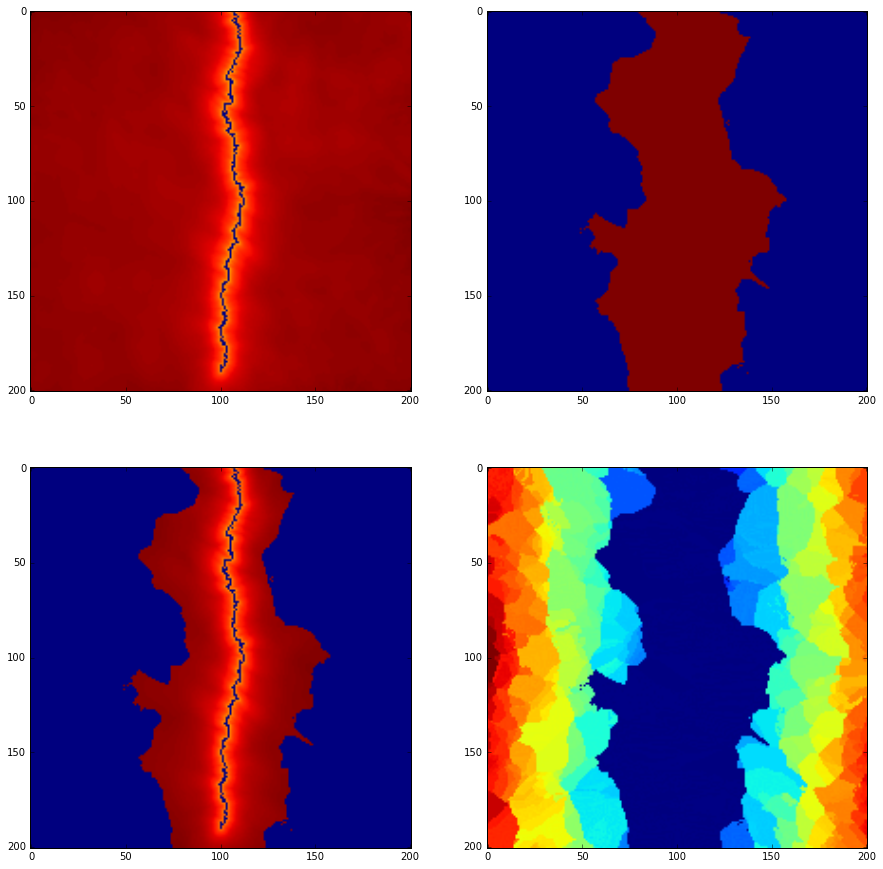

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))

ax[0][0].imshow(M)
ax[0][1].imshow(M_catchment)

M_masked = M.copy()
M_masked[np.invert(M_catchment)] = 0
ax[1][0].imshow(M_masked)

ax[1][1].imshow(np.flipud(np.min(distances, axis=1).reshape(M.shape)))

print "Catchment area is", np.sum(indices)